# Last step of the stOrder workflow: combining GEX-based and physical space based distances b/w cell states to jointly derive the trajectory of invading trophoblast

02.2022, updated after bug fix

For the GEX part I am using cell state connectivities derived by PAGA (notebook S0) for invading trophoblast of donor P13 (SN + multiome atlas)

For the spatail part I am using spatial covariance values derived with the spatial covariance model (notebooks S1 and S2)
with all samples of donor P13 (SN+multiome) and donors P13, P14 and Hrv43 spatail data (relevant 8 chips)

There is an opportunity to subset the cell states that are present in each Visium chip (for instance, there are no VCT_CCC or GC in donor Hrv43 chip etc.), however even without this slightly manual intervention the inference works and manages to pinpoint the branching point population (EVT_2)

Considering only `myometrium` and `decidua_and_villi_tips` regions (based on tissue segmentation done with SpatialDE2 tissue segmenatation in `S1` notebook)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import anndata

import scanpy as sc
import scipy
import matplotlib.pyplot as plt

In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


# 1. Reading in results of spatial covariance model (smooth proximity of cell states in physical space)

Using invading trophoblast densities derived from cell2location analysis projecting donor P13 states onto donors P13, P14 and Hrv43 Visium data

In [3]:
# Visium chip IDs
IDs = ['34914_WS_PLA_S9101764',
 '34914_WS_PLA_S9101765',
 '34914_WS_PLA_S9101766',
 '34914_WS_PLA_S9101767',
 '34882_WS_PLA_S9101769',
 '34882_WS_PLA_S9101770',
 '36173_Pla_HDBR9518710',
 '36173_Pla_Camb9518737']

In [4]:
# cell state tags of invading trophoblast from cell2location object

#cell_types = ['VCT_CCC', 'EVT_1', 'EVT_2', 'EVT_3', 'eEVT', 'iEVT', 'GC']
cell_types = ['w_sf_VCT_CCC_hybrid',
 'w_sf_EVT_1_hybrid',
 'w_sf_EVT_2_hybrid',
 'w_sf_eEVT_hybrid',
 'w_sf_iEVT_hybrid',
 'w_sf_GC_hybrid']

### Optional (skipping in the end): implementing per chip manual selection of cell states that are actually present in each chip (to eliminate anyd off-target mapping happening in cell2location analysis)

In [5]:
# cell states relevant for each slide - taking all results for all Visium chips

cell_states_of_interest = {}

for ID in IDs:
    print(ID)
    cell_states_of_interest[ID] = cell_types

34914_WS_PLA_S9101764
34914_WS_PLA_S9101765
34914_WS_PLA_S9101766
34914_WS_PLA_S9101767
34882_WS_PLA_S9101769
34882_WS_PLA_S9101770
36173_Pla_HDBR9518710
36173_Pla_Camb9518737


In [6]:
# 22.02.2022 results
# with new cell2location results for the full P13 atlas (with run_regression and pre-mRNA-aligned Visium)
# spot selection based on tissue segmentation of the chips into regions using SpatialDE2 (notebook S2)
# updated after bug fix

# with l_init = 29

# reading results for run with cell densities

results_ct_density = {}
corr_dfs_ct_density = {}

for ID in IDs:
    print(ID)
    results_ct_density[ID] = pd.read_csv('/nfs/team292/aa22/SpatialDE_colocation_model_related/results/20220222_SpatialDE_pairwise_corr_model_region_spot_selection_chip_' + ID + '_kernel_lenghtscales_29.csv', index_col=0)
    
    # removing unnecesary stuff from the cell type name
    #results_ct_density[ID]['ct1'] = [elem[5:-4] for elem in results_ct_density[ID]['ct1']]
    #results_ct_density[ID]['ct2'] = [elem[5:-4] for elem in results_ct_density[ID]['ct2']]

    corr_dfs_ct_density[ID] = pd.DataFrame(index = cell_states_of_interest[ID],
                       columns = cell_states_of_interest[ID])
    
    for row in list(results_ct_density[ID].index):
        curr_data = results_ct_density[ID].loc[row]
        curr_ct1 = results_ct_density[ID].loc[row]['ct1']
        curr_ct2 = results_ct_density[ID].loc[row]['ct2']
        curr_corr = results_ct_density[ID].loc[row]['cor']
    
        corr_dfs_ct_density[ID].loc[curr_ct1, curr_ct2] = curr_corr
        corr_dfs_ct_density[ID].loc[curr_ct2, curr_ct1] = curr_corr
        
    # for ease of eye inspection
    for ct in cell_types:
        corr_dfs_ct_density[ID].loc[ct,ct] = 0
        
        
    # subset to only those cell states that are relevant for each chip
    corr_dfs_ct_density[ID] = corr_dfs_ct_density[ID].loc[cell_states_of_interest[ID],cell_states_of_interest[ID]]

    corr_dfs_ct_density[ID] = corr_dfs_ct_density[ID].astype(float)

34914_WS_PLA_S9101764
34914_WS_PLA_S9101765
34914_WS_PLA_S9101766
34914_WS_PLA_S9101767
34882_WS_PLA_S9101769
34882_WS_PLA_S9101770
36173_Pla_HDBR9518710
36173_Pla_Camb9518737


In [7]:
def plot_heatmap(data_table):
    sns.heatmap(data_table, cmap='RdBu_r', vmax = max(abs(np.max(data_table.values)), abs(np.min(data_table.values))),
                center=0,
               #vmin = -max(abs(np.max(data_table.values)), abs(np.min(data_table.values))),
                #annot=True
               )

In [8]:
corr_dfs_ct_density['34882_WS_PLA_S9101769']

w_sf_VCT_CCC_hybrid  w_sf_EVT_1_hybrid  \
w_sf_VCT_CCC_hybrid             0.000000          -0.045626   
w_sf_EVT_1_hybrid              -0.045626           0.000000   
w_sf_EVT_2_hybrid              -0.077723           0.138033   
w_sf_eEVT_hybrid               -0.112905           0.031226   
w_sf_iEVT_hybrid               -0.105404          -0.063888   
w_sf_GC_hybrid                  0.161235          -0.206554   

                     w_sf_EVT_2_hybrid  w_sf_eEVT_hybrid  w_sf_iEVT_hybrid  \
w_sf_VCT_CCC_hybrid          -0.077723         -0.112905         -0.105404   
w_sf_EVT_1_hybrid             0.138033          0.031226         -0.063888   
w_sf_EVT_2_hybrid             0.000000          0.043532          0.110027   
w_sf_eEVT_hybrid              0.043532          0.000000          0.021935   
w_sf_iEVT_hybrid              0.110027          0.021935          0.000000   
w_sf_GC_hybrid               -0.468164         -0.145645         -0.130666   

                     w_sf_GC_hybrid  
w_sf_VCT_CCC_hybrid        0.161235  
w_sf_EVT_1_hybrid         -0.206554  
w_sf_EVT_2_hybrid         -0.468164  
w_sf_eEVT_hybrid          -0.145645  
w_sf_iEVT_hybrid          -0.130666  
w_sf_GC_hybrid             0.000000

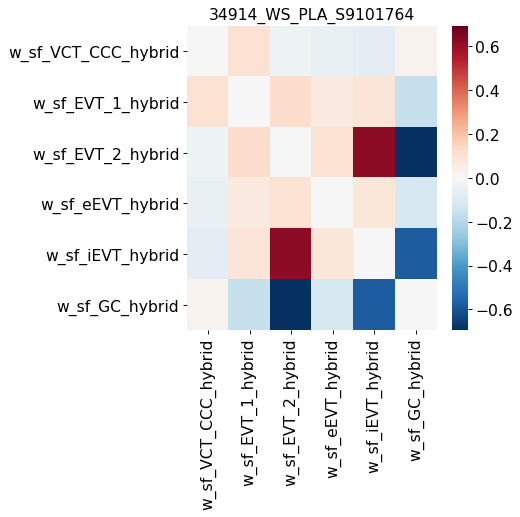

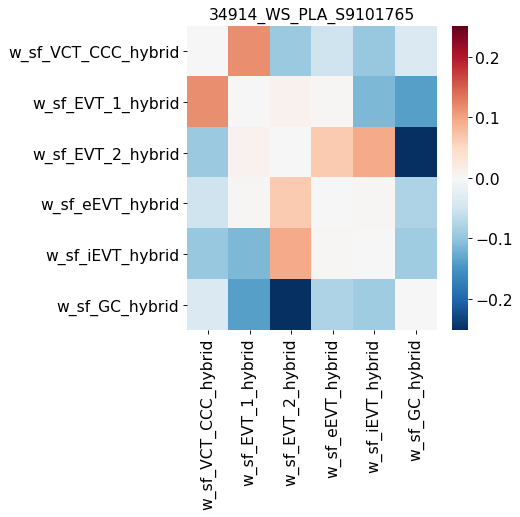

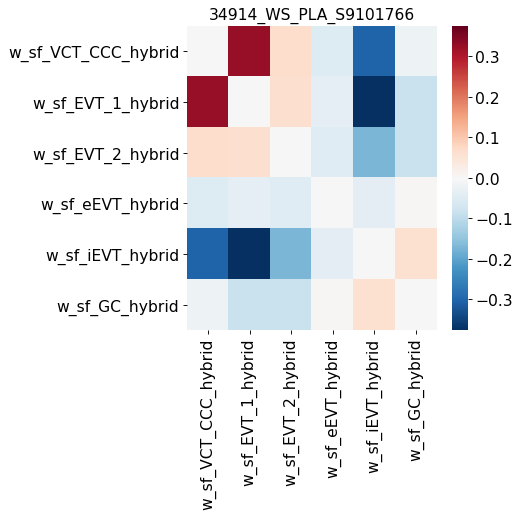

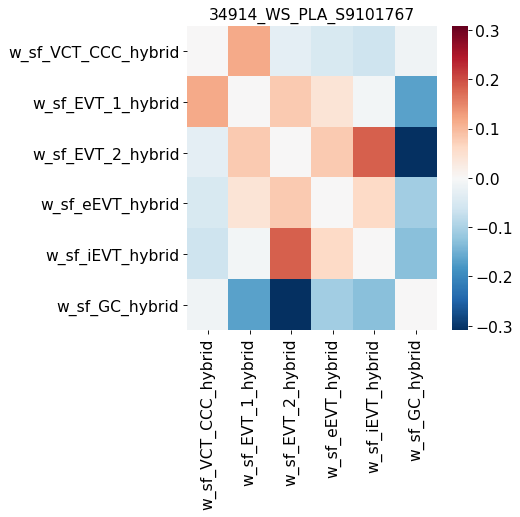

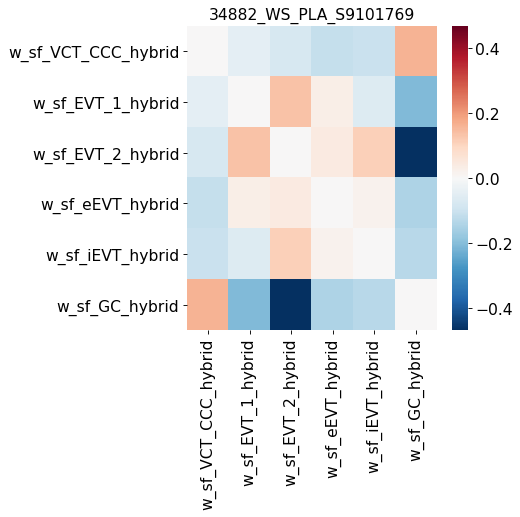

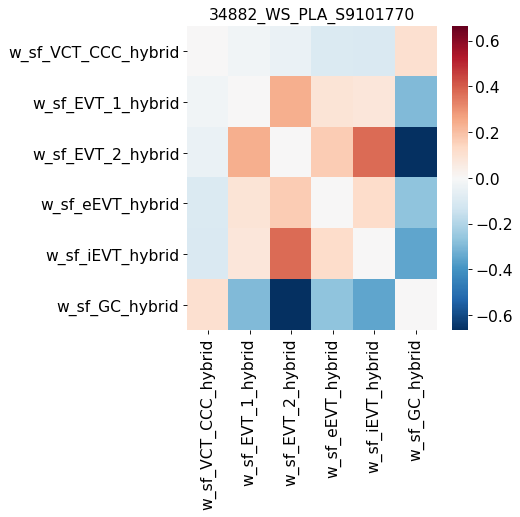

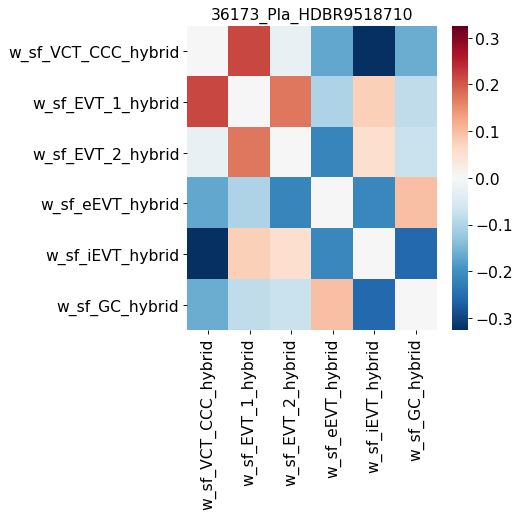

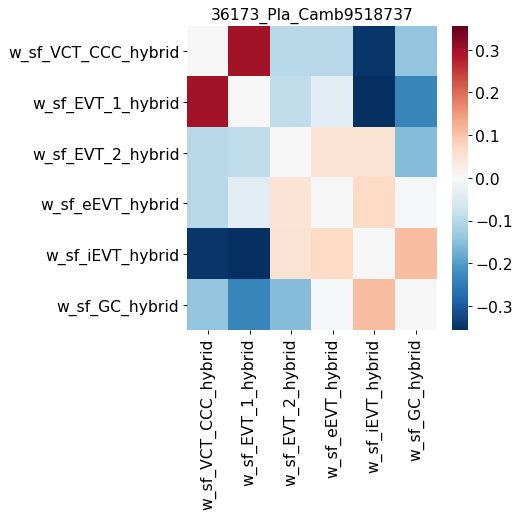

In [9]:
# l_init = 29
for ID in IDs:
    #print(ID)
    plt.figure(figsize=(5,5))
    plt.title(ID)
    plot_heatmap(corr_dfs_ct_density[ID])

In [10]:
IDs

['34914_WS_PLA_S9101764',
 '34914_WS_PLA_S9101765',
 '34914_WS_PLA_S9101766',
 '34914_WS_PLA_S9101767',
 '34882_WS_PLA_S9101769',
 '34882_WS_PLA_S9101770',
 '36173_Pla_HDBR9518710',
 '36173_Pla_Camb9518737']

In [11]:
# getting to a matrix of pairwise spatial covariance values for all invading trophoblast cell states
# here just summing up the matrices for all chips, later will scale the absolute values

corr_df_ct_density = corr_dfs_ct_density['34914_WS_PLA_S9101765'].add(corr_dfs_ct_density['34914_WS_PLA_S9101764'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34914_WS_PLA_S9101766'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34914_WS_PLA_S9101767'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34882_WS_PLA_S9101769'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['34882_WS_PLA_S9101770'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['36173_Pla_HDBR9518710'], fill_value=0)
corr_df_ct_density = corr_df_ct_density.add(corr_dfs_ct_density['36173_Pla_Camb9518737'], fill_value=0)

# to avoid numpy errors
corr_df_ct_density = corr_df_ct_density.astype(float)

In [12]:
# order cell states to inspect visually in a convenient way from VCT_CCC up to GC
ct_in_order = ['w_sf_VCT_CCC_hybrid','w_sf_EVT_1_hybrid','w_sf_EVT_2_hybrid','w_sf_eEVT_hybrid','w_sf_iEVT_hybrid','w_sf_GC_hybrid']

corr_df_ct_density = corr_df_ct_density.loc[ct_in_order,ct_in_order]

In [13]:
# for less busy plot
corr_df_ct_density.columns = ['VCT_CCC', 'EVT_1', 'EVT_2',
       'eEVT', 'iEVT', 'GC']
corr_df_ct_density.index = ['VCT_CCC', 'EVT_1', 'EVT_2',
       'eEVT', 'iEVT', 'GC']

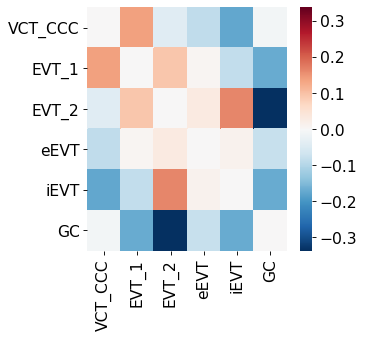

In [14]:
# 22.02.2022 results
# l_init = 29
# with NO manual limitations of the cell states
# all 8 chips

# dividing by 8 to scale for 8 chips, doesn't matter so much for now
plot_heatmap(corr_df_ct_density/8)

In [15]:
corr_df_ct_density

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
VCT_CCC  0.000000  1.108752 -0.334121 -0.681527 -1.409788 -0.079831
EVT_1    1.108752  0.000000  0.747748  0.057207 -0.662590 -1.365174
EVT_2   -0.334121  0.747748  0.000000  0.248317  1.316112 -2.694997
eEVT    -0.681527  0.057207  0.248317  0.000000  0.109936 -0.617177
iEVT    -1.409788 -0.662590  1.316112  0.109936  0.000000 -1.359038
GC      -0.079831 -1.365174 -2.694997 -0.617177 -1.359038  0.000000

# 2. Reading in results of PAGA (GEX-based connectivities of cell states)

Using results of PAGA on donor P13 SN + multiome RNA-seq data (using all donors data did not yield great results here)

### Reading fully analysed invading trophoblast dataset (SN + multiome) with computed PAGA graph

In [16]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_all_samples_analysis_202110/'

In [17]:
adata_PAGA = sc.read(save_path + 'adata_inv_troph_final_with_PAGA_20211123_corrected_annotation.h5ad')

In [18]:
adata_PAGA

AnnData object with n_obs × n_vars = 4715 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'louvain_scvi_n_latent_20', 'louvain_scvi_n_latent_8', 'x', 'y', 'z', 'dot_size', 'louvain_scvi_n_latent_20_R', 'annot_inv_troph', 'louvain_scvi_n_latent_8_R', 'louvain_scvi_n_latent_8_RR', 'annot_inv_troph_n_latent_8', 'prelim_annot_scvi_c2l_tested', 'louvain_scvi_n_latent_30', 'louvain_scvi_n_latent_30_R', 'annot_inv_troph_n_latent_30', 'annot_inv_troph_n_latent_8_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2

In [19]:
# getting more distinct colors for the zoomed in plot (donor P13 all troph)

colors_final = ['#EE2724', # EVT_1
                '#F58C74', # EVT_2
                '#726658', # GC
                #'#BC80B8', # SCT
                #'#81B2D3', # VCT
                '#88CDAF', # VCT_CCC
                #'#514C89', # VCT_fusing
                #'#3A5337', # VCT_p
                '#21479E', # eEVT
                '#FEEC6E', # iEVT
               ]

In [20]:
curr_embedding_key = 'X_umap_scVI_n_latent_8_sample'

In [21]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

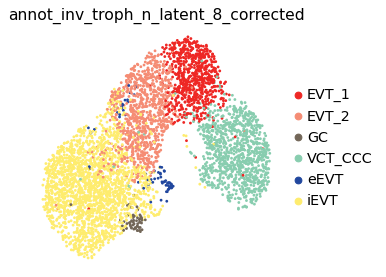

In [22]:
sc.pl.embedding(adata_PAGA, curr_embedding_key,
                color=['annot_inv_troph_n_latent_8_corrected'], 
                palette = colors_final, frameon=False,
           #save='_inv_troph_manifold_P13.pdf'
               )

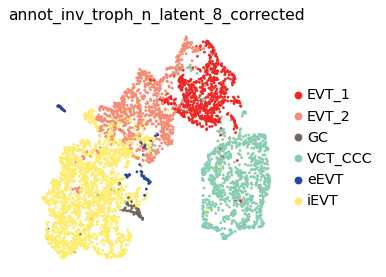

In [23]:
sc.pl.umap(adata_PAGA,
                color=['annot_inv_troph_n_latent_8_corrected'], 
                palette = colors_final, frameon=False,
           #save='_inv_troph_PAGA_denoised_manifold_P13.pdf'
          )

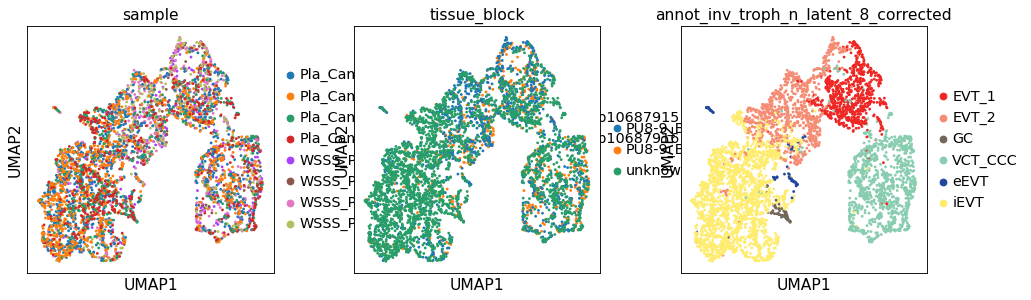

In [24]:
sc.pl.umap(adata_PAGA,color=['sample','tissue_block','annot_inv_troph_n_latent_8_corrected'], 
           #save='_inv_troph_PAGA_GEX_graph.pdf'
          )

In [25]:
adata_PAGA

AnnData object with n_obs × n_vars = 4715 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'louvain_scvi_n_latent_20', 'louvain_scvi_n_latent_8', 'x', 'y', 'z', 'dot_size', 'louvain_scvi_n_latent_20_R', 'annot_inv_troph', 'louvain_scvi_n_latent_8_R', 'louvain_scvi_n_latent_8_RR', 'annot_inv_troph_n_latent_8', 'prelim_annot_scvi_c2l_tested', 'louvain_scvi_n_latent_30', 'louvain_scvi_n_latent_30_R', 'annot_inv_troph_n_latent_30', 'annot_inv_troph_n_latent_8_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2

#### Visualising how PAGA graph looks for figures (only GEX-based trajectory)

--> added 'pos', the PAGA positions (adata.uns['paga'])


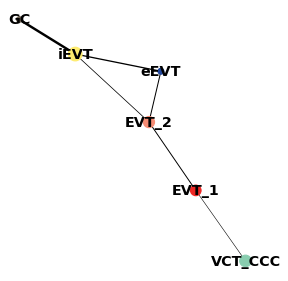

In [26]:
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], 
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.1, random_state=0,
          frameon=False,
          #save='_PAGA_GEX_only.pdf'
          )

--> added 'pos', the PAGA positions (adata.uns['paga'])


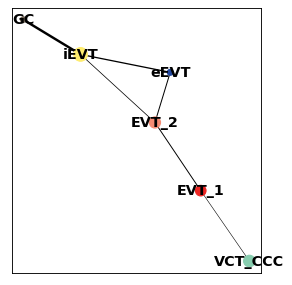

In [27]:
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], 
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.13, random_state=0)

In [28]:
adata_PAGA

AnnData object with n_obs × n_vars = 4715 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'barcode_sample_copy', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'annotation_prev', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'annotation_prev_or_removed', 'louvain_scvi_n_latent_20', 'louvain_scvi_n_latent_8', 'x', 'y', 'z', 'dot_size', 'louvain_scvi_n_latent_20_R', 'annot_inv_troph', 'louvain_scvi_n_latent_8_R', 'louvain_scvi_n_latent_8_RR', 'annot_inv_troph_n_latent_8', 'prelim_annot_scvi_c2l_tested', 'louvain_scvi_n_latent_30', 'louvain_scvi_n_latent_30_R', 'annot_inv_troph_n_latent_30', 'annot_inv_troph_n_latent_8_corrected'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2

--> added 'pos', the PAGA positions (adata.uns['paga'])


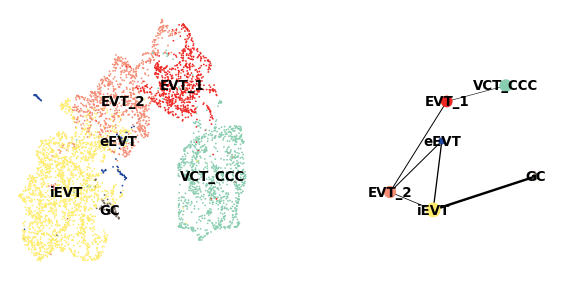

In [29]:
axs = sc.pl.paga_compare(
    adata_PAGA, title='', right_margin=0.3, size=10,
    threshold=0.05, edge_width_scale=0.5, node_size_scale=0.6, random_state=0,
    legend_fontsize=12, fontsize=50, frameon=False, save=True)

# 3. Combining GEX-based and physical space-based connectivities b/w invading trophoblast cell states to jointly derive invading trophoblast trajectory

### sc.tl.paga that has been run on adata_PAGA returns the following:

 - `connectivities`: numpy.ndarray (adata.uns['paga'][‘connectivities’])
 
The full adjacency matrix of the abstracted graph, weights correspond to confidence in the connectivities of partitions.

 - `connectivities_tree`: scipy.sparse.csr_matrix (adata.uns['paga'][‘connectivities_tree’])
 
The adjacency matrix of the tree-like subgraph that best explains the topology.


For more please see [documentation](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.paga.html)


In [30]:
# 7 cell states of invading trophobalst
np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected'])

array(['EVT_1', 'EVT_2', 'GC', 'VCT_CCC', 'eEVT', 'iEVT'], dtype=object)

In [31]:
adata_PAGA.uns['paga']

{'connectivities': <6x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 22 stored elements in Compressed Sparse Row format>,
 'connectivities_tree': <6x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 5 stored elements in Compressed Sparse Row format>,
 'groups': 'annot_inv_troph_n_latent_8_corrected',
 'pos': array([[ 3.140659  ,  7.190815  ],
        [-2.6860545 ,  0.38263425],
        [12.300603  ,  1.5673517 ],
        [ 9.204392  ,  8.38012   ],
        [ 2.637301  ,  4.221141  ],
        [ 1.7494507 , -0.96191216]], dtype=float32)}

In [32]:
adata_PAGA.uns['paga']['connectivities'].todense()

matrix([[0.        , 0.23241445, 0.        , 0.13447446, 0.        ,
         0.00737118],
        [0.23241445, 0.        , 0.        , 0.01659596, 0.24168795,
         0.17695637],
        [0.        , 0.        , 0.        , 0.00861338, 0.        ,
         0.58348132],
        [0.13447446, 0.01659596, 0.00861338, 0.        , 0.00703628,
         0.0121416 ],
        [0.        , 0.24168795, 0.        , 0.00703628, 0.        ,
         0.30855971],
        [0.00737118, 0.17695637, 0.58348132, 0.0121416 , 0.30855971,
         0.        ]])

In [33]:
np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected'])

array(['EVT_1', 'EVT_2', 'GC', 'VCT_CCC', 'eEVT', 'iEVT'], dtype=object)

In [34]:
# order:
# 0 - EVT_1
# 1 - EVT_2
# 3 - GC
# 4 - VCT_CCC
# 5 - eEVT
# 6 - iEVT

# Working with cluster connectivities

In [35]:
# to understand the order of cell states in PAGA graph
connectivities_paga = pd.DataFrame(data = adata_PAGA.uns['paga']['connectivities'].todense(),
                                   columns = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8']),
                                   index = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8']))
connectivities_paga

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
EVT_1    0.000000  0.232414  0.000000  0.134474  0.000000  0.007371
EVT_2    0.232414  0.000000  0.000000  0.016596  0.241688  0.176956
GC       0.000000  0.000000  0.000000  0.008613  0.000000  0.583481
VCT_CCC  0.134474  0.016596  0.008613  0.000000  0.007036  0.012142
eEVT     0.000000  0.241688  0.000000  0.007036  0.000000  0.308560
iEVT     0.007371  0.176956  0.583481  0.012142  0.308560  0.000000

# Combining PAGA-derived cluster connectivities and Spatial Covariance model-derived distances into 1 metric

In [36]:
corr_df_ct_density

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
VCT_CCC  0.000000  1.108752 -0.334121 -0.681527 -1.409788 -0.079831
EVT_1    1.108752  0.000000  0.747748  0.057207 -0.662590 -1.365174
EVT_2   -0.334121  0.747748  0.000000  0.248317  1.316112 -2.694997
eEVT    -0.681527  0.057207  0.248317  0.000000  0.109936 -0.617177
iEVT    -1.409788 -0.662590  1.316112  0.109936  0.000000 -1.359038
GC      -0.079831 -1.365174 -2.694997 -0.617177 -1.359038  0.000000

In [37]:
# disregard negative values from spatial covariance matrix since we operate with connectivities here
# or trying to use values that can be interpreted as "how close the 2 cell states are in space? (with smooth transitions of density)"
corr_df_ct_density_nonneg = corr_df_ct_density.clip(lower=0)


In [38]:
# handle negative values separately?
corr_df_ct_density_nonneg

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT   GC
VCT_CCC  0.000000  1.108752  0.000000  0.000000  0.000000  0.0
EVT_1    1.108752  0.000000  0.747748  0.057207  0.000000  0.0
EVT_2    0.000000  0.747748  0.000000  0.248317  1.316112  0.0
eEVT     0.000000  0.057207  0.248317  0.000000  0.109936  0.0
iEVT     0.000000  0.000000  1.316112  0.109936  0.000000  0.0
GC       0.000000  0.000000  0.000000  0.000000  0.000000  0.0

### plotting this matrix for figure making

In [39]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

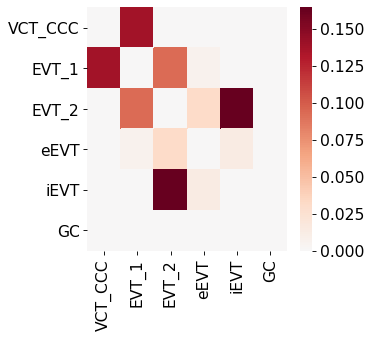

In [40]:
# for figure making - UPDATED
plot_heatmap(corr_df_ct_density_nonneg/8)
plt.savefig('./figures/20220222_sp_cov_heatmap_for_Fig2A.pdf', bbox_inches='tight')

### Scaling both tables (from PAGA and spatial covariance model) to the same abs max so that the values are comparable

In [41]:
# let's try to scale both tables to the same abs max so that the values are comparable
np.max(corr_df_ct_density_nonneg.values)

1.3161116435652447

In [42]:
np.min(corr_df_ct_density_nonneg.values)

0.0

In [43]:
np.max(connectivities_paga.values)

0.5834813244372389

In [44]:
np.min(connectivities_paga.values)

0.0

In [45]:
connectivities_paga = connectivities_paga * np.max(corr_df_ct_density_nonneg.values) / np.max(connectivities_paga.values)

In [46]:
np.max(connectivities_paga.values)

1.3161116435652447

In [47]:
corr_df_ct_density_nonneg

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT   GC
VCT_CCC  0.000000  1.108752  0.000000  0.000000  0.000000  0.0
EVT_1    1.108752  0.000000  0.747748  0.057207  0.000000  0.0
EVT_2    0.000000  0.747748  0.000000  0.248317  1.316112  0.0
eEVT     0.000000  0.057207  0.248317  0.000000  0.109936  0.0
iEVT     0.000000  0.000000  1.316112  0.109936  0.000000  0.0
GC       0.000000  0.000000  0.000000  0.000000  0.000000  0.0

# There is an argument `solid_edges` in sc.pl.paga() that can take custom connectivity edges to plot instead of the default adata.uns['paga']['connectivities'] - use this and pass joint connectivity metric

In [48]:
def calculate_combined_connectivities(df_paga_conn,
                              df_spatial_conn,
                              w = 0.3, # weight / significance of GEX distances in the overall distances - before it was for spatial
                              combinationfun = lambda x, y, w: x * w + y * (1 - w)
                             ):

    return combinationfun(df_paga_conn, df_spatial_conn, w)


In [49]:
ct_in_order = ['VCT_CCC','EVT_1','EVT_2','eEVT','iEVT','GC']
connectivities_paga = connectivities_paga.loc[ct_in_order,ct_in_order]

In [50]:
connectivities_paga

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
VCT_CCC  0.000000  0.303323  0.037434  0.015871  0.027387  0.019429
EVT_1    0.303323  0.000000  0.524238  0.000000  0.016627  0.000000
EVT_2    0.037434  0.524238  0.000000  0.545156  0.399146  0.000000
eEVT     0.015871  0.000000  0.545156  0.000000  0.695993  0.000000
iEVT     0.027387  0.016627  0.399146  0.695993  0.000000  1.316112
GC       0.019429  0.000000  0.000000  0.000000  1.316112  0.000000

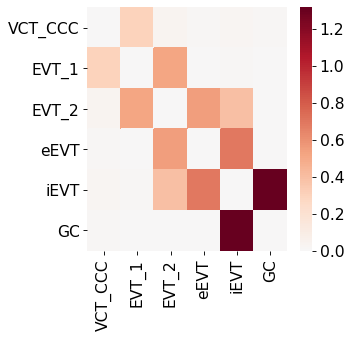

In [51]:
# saving this plot for making figure 2A - same as before
plot_heatmap(connectivities_paga)
plt.savefig('./figures/20220222_paga_gex_conn_heatmap_for_Fig2A.pdf', bbox_inches='tight')

In [52]:
corr_df_ct_density_nonneg

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT   GC
VCT_CCC  0.000000  1.108752  0.000000  0.000000  0.000000  0.0
EVT_1    1.108752  0.000000  0.747748  0.057207  0.000000  0.0
EVT_2    0.000000  0.747748  0.000000  0.248317  1.316112  0.0
eEVT     0.000000  0.057207  0.248317  0.000000  0.109936  0.0
iEVT     0.000000  0.000000  1.316112  0.109936  0.000000  0.0
GC       0.000000  0.000000  0.000000  0.000000  0.000000  0.0

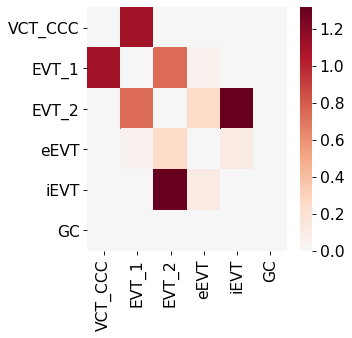

In [53]:
# with NO manual cell type constraints per chip
# 22.02.2021 results
plot_heatmap(corr_df_ct_density_nonneg)

In [54]:
# for different values of w - weight for spatial part
combined_connectivities = {}

w_values = [np.round(i*0.01, 2) for i in range(101)]

for w_value in w_values:
    #print(w_value)
    combined_connectivities['w_' + str(w_value)] = {}
    
    combined_connectivities['w_' + str(w_value)] = calculate_combined_connectivities(connectivities_paga, 
                                                                                     corr_df_ct_density_nonneg,
                                                                                                 w = w_value)
    
    # ordering columns and rows for consistency as they are ordered by np.unique
    #col_row_order = ['VCT_CCC', 'EVT_1', 'EVT_2', 'EVT_3', 'eEVT', 'iEVT', 'GC']
    col_row_order = list(np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8']))
    combined_connectivities['w_' + str(w_value)] = combined_connectivities['w_' + str(w_value)].loc[col_row_order, col_row_order]
    
    #combined_connectivities['w_' + str(w_value)].to_csv('./20210131_cell_type_connectivity_matrix_invading_trophoblast_donor_P13_combined_metric_w_' + str(w_value) + '.csv')
    

In [55]:
combined_connectivities.keys()

dict_keys(['w_0.0', 'w_0.01', 'w_0.02', 'w_0.03', 'w_0.04', 'w_0.05', 'w_0.06', 'w_0.07', 'w_0.08', 'w_0.09', 'w_0.1', 'w_0.11', 'w_0.12', 'w_0.13', 'w_0.14', 'w_0.15', 'w_0.16', 'w_0.17', 'w_0.18', 'w_0.19', 'w_0.2', 'w_0.21', 'w_0.22', 'w_0.23', 'w_0.24', 'w_0.25', 'w_0.26', 'w_0.27', 'w_0.28', 'w_0.29', 'w_0.3', 'w_0.31', 'w_0.32', 'w_0.33', 'w_0.34', 'w_0.35', 'w_0.36', 'w_0.37', 'w_0.38', 'w_0.39', 'w_0.4', 'w_0.41', 'w_0.42', 'w_0.43', 'w_0.44', 'w_0.45', 'w_0.46', 'w_0.47', 'w_0.48', 'w_0.49', 'w_0.5', 'w_0.51', 'w_0.52', 'w_0.53', 'w_0.54', 'w_0.55', 'w_0.56', 'w_0.57', 'w_0.58', 'w_0.59', 'w_0.6', 'w_0.61', 'w_0.62', 'w_0.63', 'w_0.64', 'w_0.65', 'w_0.66', 'w_0.67', 'w_0.68', 'w_0.69', 'w_0.7', 'w_0.71', 'w_0.72', 'w_0.73', 'w_0.74', 'w_0.75', 'w_0.76', 'w_0.77', 'w_0.78', 'w_0.79', 'w_0.8', 'w_0.81', 'w_0.82', 'w_0.83', 'w_0.84', 'w_0.85', 'w_0.86', 'w_0.87', 'w_0.88', 'w_0.89', 'w_0.9', 'w_0.91', 'w_0.92', 'w_0.93', 'w_0.94', 'w_0.95', 'w_0.96', 'w_0.97', 'w_0.98', 'w_0.99',

In [56]:
combined_connectivities['w_0.4']

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
EVT_1    0.000000  0.658344  0.000000  0.786580  0.034324  0.006651
EVT_2    0.658344  0.000000  0.000000  0.014974  0.367052  0.949325
GC       0.000000  0.000000  0.000000  0.007771  0.000000  0.526445
VCT_CCC  0.786580  0.014974  0.007771  0.000000  0.006348  0.010955
eEVT     0.034324  0.367052  0.000000  0.006348  0.000000  0.344359
iEVT     0.006651  0.949325  0.526445  0.010955  0.344359  0.000000

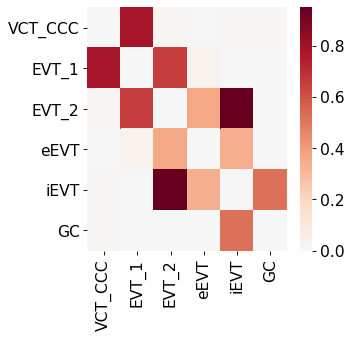

In [57]:
# plotting for making figure 2A - UPDATED
plot_heatmap(combined_connectivities['w_0.4'].loc[ct_in_order, ct_in_order])
plt.savefig('./figures/20220222_combined_heatmap_w_gex_0.4_for_Fig2A.pdf', bbox_inches = 'tight')

In [58]:
# adding these connectivities to adata.uns['paga'] to visualise later
for w_value in w_values:
    #print(w_value)
    curr_mtx_sparse = scipy.sparse.csr_matrix(combined_connectivities['w_' + str(w_value)].values)
    adata_PAGA.uns['paga']['combined_connectivities_w_gex_' + str(w_value)] = curr_mtx_sparse

In [59]:
adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.0']

<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [60]:
pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.0'].todense())

0         1    2         3         4         5
0  0.000000  0.747748  0.0  1.108752  0.057207  0.000000
1  0.747748  0.000000  0.0  0.000000  0.248317  1.316112
2  0.000000  0.000000  0.0  0.000000  0.000000  0.000000
3  1.108752  0.000000  0.0  0.000000  0.000000  0.000000
4  0.057207  0.248317  0.0  0.000000  0.000000  0.109936
5  0.000000  1.316112  0.0  0.000000  0.109936  0.000000

In [61]:
pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.9'].todense())

0         1         2         3         4         5
0  0.000000  0.546589  0.000000  0.383866  0.005721  0.014964
1  0.546589  0.000000  0.000000  0.033691  0.515472  0.490843
2  0.000000  0.000000  0.000000  0.017486  0.000000  1.184500
3  0.383866  0.033691  0.017486  0.000000  0.014284  0.024648
4  0.005721  0.515472  0.000000  0.014284  0.000000  0.637387
5  0.014964  0.490843  1.184500  0.024648  0.637387  0.000000

In [62]:
pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_0.6'].todense())

0         1         2         3         4         5
0  0.000000  0.613642  0.000000  0.625495  0.022883  0.009976
1  0.613642  0.000000  0.000000  0.022460  0.426420  0.765932
2  0.000000  0.000000  0.000000  0.011657  0.000000  0.789667
3  0.625495  0.022460  0.011657  0.000000  0.009523  0.016432
4  0.022883  0.426420  0.000000  0.009523  0.000000  0.461570
5  0.009976  0.765932  0.789667  0.016432  0.461570  0.000000

In [63]:
adata_PAGA.uns['annot_inv_troph_n_latent_8_corrected_colors']

['#ee2724', '#f58c74', '#726658', '#88cdaf', '#21479e', '#feec6e']

In [64]:
adata_PAGA.uns['annot_inv_troph_n_latent_8_corrected_colors'] = ['#7edeb6', # EVT_1 - need to change
                '#bc80bd', # EVT_2 - need to change
                '#003dad', # GC - need to change
                '#ded97e', # VCT_CCC
                '#FF1200', # eEVT
                '#ffed6f', # iEVT - need to change
               ]

--> added 'pos', the PAGA positions (adata.uns['paga'])


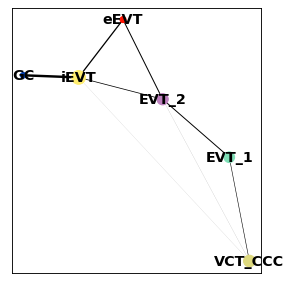

In [65]:
# original paga connectivities (only GEX-based)
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='connectivities',
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.01, random_state=0)

### in the next few cells I am trying to play with the `threshold` argument to see if I can get rid of nodes that would make this graph **ACYCLIC**, connected and with 1 branching point

And if what I see doesn't have 2 known endpoints - eEVT & GC - then I go and refine it adding spatial connectivities with different coefficients

In [66]:
adata_PAGA.uns['annot_inv_troph_n_latent_8_corrected_colors'] = colors_final

--> added 'pos', the PAGA positions (adata.uns['paga'])


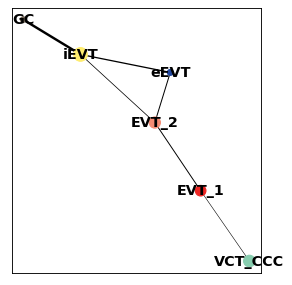

In [67]:
# original paga connectivities 
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='connectivities',
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.02, random_state=0)

--> added 'pos', the PAGA positions (adata.uns['paga'])


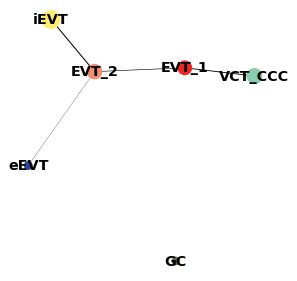

In [68]:
# with 22.02.2022 results with l_init = 29
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='combined_connectivities_w_gex_0.1',
           edge_width_scale=0.1, node_size_scale=1, threshold=0.2, random_state=0,
          frameon=False, 
          )

In [69]:
curr_df = pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_' + str(0.4)].todense(),
                          index = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']),
                          columns = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']))

In [70]:
curr_df

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
EVT_1    0.000000  0.658344  0.000000  0.786580  0.034324  0.006651
EVT_2    0.658344  0.000000  0.000000  0.014974  0.367052  0.949325
GC       0.000000  0.000000  0.000000  0.007771  0.000000  0.526445
VCT_CCC  0.786580  0.014974  0.007771  0.000000  0.006348  0.010955
eEVT     0.034324  0.367052  0.000000  0.006348  0.000000  0.344359
iEVT     0.006651  0.949325  0.526445  0.010955  0.344359  0.000000

In [71]:
## NEW way of telling whether we have correct topology of the tree with a given w parameter
# correct here means that there are exactly 5 egdes b/w: 
# VCT_CCC & EVT_1, EVT_1 & EVT_2, EVT_2 & eEVT, EVT_2 & iEVT and iEVT and GC

# which w_values yield a tree of correct topology?
w_values_correct_tree = []

for w_value in w_values:
    #adata_PAGA.uns['paga']['combined_connectivities_w_sp_' + str(w_value)]
    print(w_value)
    
    # checking if there exists a threshold that would only pick top 6 correct edges
    curr_df = pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_' + str(w_value)].todense(),
                          index = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']),
                          columns = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']))
    
    # need to operate with values above diagonal only to avoid duplicates (or below but not altogether)
    curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
    
    
    # without duplicates from opposite triagnle of matrix
    conn_values = [item for sublist in curr_df_upper.values.tolist() for item in sublist]
    # removing nans and zeros
    conn_values = [x for x in conn_values if str(x) != 'nan']
    conn_values = [x for x in conn_values if x > 0]
    #conn_values
    
    # from the values list we need to identify top 6 edges
    cutoff = np.quantile(conn_values, 1-5/len(conn_values))
    
    print('cutoff here is', cutoff)
    
    # and using the cutoff we need to check that the values selected have correct labels (columns and rows) 
    curr_df_selected = curr_df[curr_df > cutoff]
    
    
    # dictionary of ct -> conn cts (in tree) according to top 6 selected edges
    connected_cts = []
    
    for col in curr_df_selected.columns:
        connected_cts.append([[col, ct] for ct in list(curr_df_selected[~curr_df_selected[col].isnull()].index)])
        
    connected_cts = [item for sublist in connected_cts for item in sublist]        
        
    print('current connected cell types are:', connected_cts)
    
    
    correct_edges = ['EVT_1_EVT_2', 'EVT_2_EVT_1',
                 
     'EVT_2_eEVT', 'eEVT_EVT_2',

     'EVT_2_iEVT', 'iEVT_EVT_2',

     'GC_iEVT', 'iEVT_GC',

     'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
    
    
    connected_cts = [elem[0] + '_' + elem[1] for elem in connected_cts]
    
    print(connected_cts, '\n', correct_edges)
    
    # intersection with correct edges list
    
    print(len(set(set(connected_cts) & set(correct_edges))))
    
    if len(set(set(connected_cts) & set(correct_edges))) == 10:
        w_values_correct_tree.append(w_value)

    
    # what we want to check is essentially whether top values in this dataframe (connectivities) are in expected positions (in correct edges)
    
    

0.0
cutoff here is 0.10114769117237193
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
8
0.01
cutoff here is 0.08128532699826066
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 

<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3dd

cutoff here is 0.2886375177841998
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['iEVT', 'EVT_2'], ['iEVT', 'GC']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'iEVT_EVT_2', 'iEVT_GC'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
10
0.27
cutoff here is 0.29329301554571074
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['iEVT', 'EVT_2'], ['iEVT', 'GC']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'iEVT_EVT_2', 'iEVT_GC'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_

<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3dd

8
0.49
cutoff here is 0.3951579597301757
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'GC'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_GC', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
8
0.5
cutoff here is 0.39933142748830147
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'GC'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_GC', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_e

<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3dd

current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'GC'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_GC', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
8
0.72
cutoff here is 0.48987521092198916
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'GC'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_GC', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_

<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3dd

current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['eEVT', 'EVT_2'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'GC'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'GC_iEVT', 'eEVT_EVT_2', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_GC', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
8
0.93
cutoff here is 0.4028825750585683
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['eEVT', 'EVT_2'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'GC'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'GC_iEVT', 'eEVT_EVT_2', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_GC', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_

<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3ddb5>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-71-356cd4f3dd

In [73]:
w_values_correct_tree

[0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47]

--> added 'pos', the PAGA positions (adata.uns['paga'])


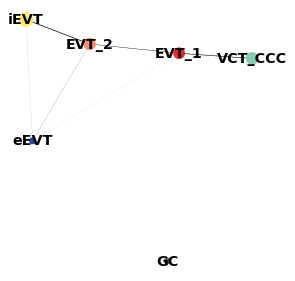

In [74]:
# same as above (paga conn) but just rescaled to a different max value (to be comparable to spatail cov table values)
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='combined_connectivities_w_gex_0.0',
           edge_width_scale=0.5/8, node_size_scale=0.6, threshold=0.01, random_state=0,
          frameon=False, save = '_PAGA_only_sp_cov.pdf')

In [75]:
adata_PAGA.uns['paga'].keys()

dict_keys(['connectivities', 'connectivities_tree', 'groups', 'pos', 'combined_connectivities_w_gex_0.0', 'combined_connectivities_w_gex_0.01', 'combined_connectivities_w_gex_0.02', 'combined_connectivities_w_gex_0.03', 'combined_connectivities_w_gex_0.04', 'combined_connectivities_w_gex_0.05', 'combined_connectivities_w_gex_0.06', 'combined_connectivities_w_gex_0.07', 'combined_connectivities_w_gex_0.08', 'combined_connectivities_w_gex_0.09', 'combined_connectivities_w_gex_0.1', 'combined_connectivities_w_gex_0.11', 'combined_connectivities_w_gex_0.12', 'combined_connectivities_w_gex_0.13', 'combined_connectivities_w_gex_0.14', 'combined_connectivities_w_gex_0.15', 'combined_connectivities_w_gex_0.16', 'combined_connectivities_w_gex_0.17', 'combined_connectivities_w_gex_0.18', 'combined_connectivities_w_gex_0.19', 'combined_connectivities_w_gex_0.2', 'combined_connectivities_w_gex_0.21', 'combined_connectivities_w_gex_0.22', 'combined_connectivities_w_gex_0.23', 'combined_connectiviti

# Plotting a tree representative of the correct topology that is derived for w values (GEX contribution) between 0.16 and 0.47

--> added 'pos', the PAGA positions (adata.uns['paga'])


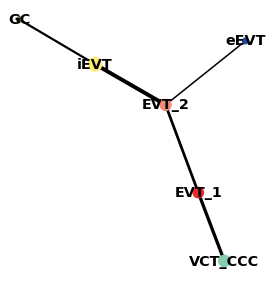

In [76]:
sc.pl.paga(adata_PAGA, color=['annot_inv_troph_n_latent_8_corrected'], solid_edges='combined_connectivities_w_gex_0.4',
           edge_width_scale=0.5, node_size_scale=0.6, threshold=0.35, random_state=0,
          frameon=False, 
           #save = '_combined_20220222_w_gex_0.4.pdf'
          )

# Testing multiplicative combination of PAGA connectivities and spatial covariance

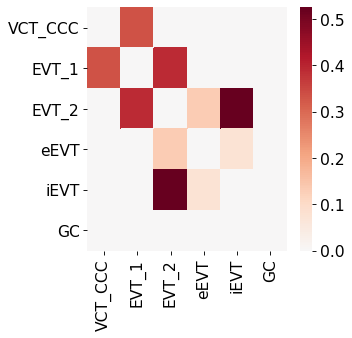

In [77]:
combined_connectivities_mult = calculate_combined_connectivities(connectivities_paga, corr_df_ct_density_nonneg, 
                                                                 combinationfun=lambda x, y, w: x * y).loc[col_row_order, col_row_order]
plot_heatmap(combined_connectivities_mult.loc[ct_in_order, ct_in_order])

--> added 'pos', the PAGA positions (adata.uns['paga'])


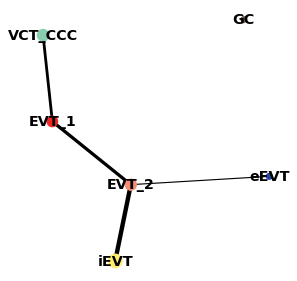

In [78]:
adata_PAGA.uns["paga"]["combined_connectivities_mult"] = scipy.sparse.csr_matrix(combined_connectivities_mult.values)
sc.pl.paga(adata_PAGA, color=["annot_inv_troph_n_latent_8_corrected"], solid_edges="combined_connectivities_mult", edge_width_scale=1, node_size_scale=0.6, threshold=0.1, random_state=0, frameon=False)

# Testing additive + multiplicative combination of PAGA connectivities and spatial covariance

We use the most general form 
β
(
α
P
+
(
1
−
α
)
S
)
+
(
1
−
β
)
P
S
, where 
P
 is the PAGA connectivity matrix and 
S
 is the spatial correlation matrix. To reduce the space of combinations, we fix 
α
=
0.4

In [79]:
combined_connectivities = {}

alpha = 0.4
beta_values = [np.round(i*0.01, 2) for i in range(101)]
for beta_value in beta_values:
    combined_connectivities[beta_value] = calculate_combined_connectivities(connectivities_paga, 
                                                                                     corr_df_ct_density_nonneg,
                                                                                                 w = beta_value, combinationfun=lambda x, y, w: w * (alpha * x + (1 - alpha) * y) + (1 - w) * x * y).loc[col_row_order, col_row_order]


In [80]:
## NEW way of telling whether we have correct topology of the tree with a given w parameter
# correct here means that there are exactly 5 egdes b/w: 
# VCT_CCC & EVT_1, EVT_1 & EVT_2, EVT_2 & eEVT, EVT_2 & iEVT and iEVT and GC

# which w_values yield a tree of correct topology?
beta_values_correct_tree = []

for beta_value in beta_values:
    #adata_PAGA.uns['paga']['combined_connectivities_w_sp_' + str(w_value)]
    print(beta_value)
    
    # checking if there exists a threshold that would only pick top 6 correct edges
    #curr_df = pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_' + str(w_value)].todense(),
    #                      index = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']),
    #                      columns = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']))
    
    curr_df = combined_connectivities[beta_value]
    
    adata_PAGA.uns["paga"][f"combined_connectivities_general_w_{beta_value}"] = scipy.sparse.csr_matrix(curr_df.to_numpy())

    
    # need to operate with values above diagonal only to avoid duplicates (or below but not altogether)
    curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
    
    
    # without duplicates from opposite triagnle of matrix
    conn_values = [item for sublist in curr_df_upper.values.tolist() for item in sublist]
    # removing nans and zeros
    conn_values = [x for x in conn_values if str(x) != 'nan']
    conn_values = [x for x in conn_values if x > 0]
    #conn_values
    
    # from the values list we need to identify top 6 edges
    cutoff = np.quantile(conn_values, 1-5/len(conn_values))
    
    print('cutoff here is', cutoff)
    
    # and using the cutoff we need to check that the values selected have correct labels (columns and rows) 
    curr_df_selected = curr_df[curr_df > cutoff]
    
    
    # dictionary of ct -> conn cts (in tree) according to top 6 selected edges
    connected_cts = []
    
    for col in curr_df_selected.columns:
        connected_cts.append([[col, ct] for ct in list(curr_df_selected[~curr_df_selected[col].isnull()].index)])
        
    connected_cts = [item for sublist in connected_cts for item in sublist]        
        
    print('current connected cell types are:', connected_cts)
    
    
    correct_edges = ['EVT_1_EVT_2', 'EVT_2_EVT_1',
                 
     'EVT_2_eEVT', 'eEVT_EVT_2',

     'EVT_2_iEVT', 'iEVT_EVT_2',

     'GC_iEVT', 'iEVT_GC',

     'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
    
    
    connected_cts = [elem[0] + '_' + elem[1] for elem in connected_cts]
    
    print(connected_cts, '\n', correct_edges)
    
    # intersection with correct edges list
    
    print(len(set(set(connected_cts) & set(correct_edges))))
    
    if len(set(set(connected_cts) & set(correct_edges))) == 10:
        beta_values_correct_tree.append(beta_value)

    
    # what we want to check is essentially whether top values in this dataframe (connectivities) are in expected positions (in correct edges)
    
    

0.0
cutoff here is 0.07651465000155373
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['iEVT', 'EVT_2']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'iEVT_EVT_2'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
8
0.01
cutoff here is 0.03606804874308947
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['eEVT', 'iEVT'], ['iEVT', 'EVT_2'], ['iEVT', 'eEVT']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'eEVT_iEVT', 'iEVT_EVT_2', 'iEVT_eEVT'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT

<ipython-input-80-fd4dcfaa9e24>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-80-fd4dcfaa9e24>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-80-fd4dcfaa9e

cutoff here is 0.1798475217839645
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['iEVT', 'EVT_2'], ['iEVT', 'GC']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'iEVT_EVT_2', 'iEVT_GC'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
10
0.37
cutoff here is 0.18360346556034574
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['iEVT', 'EVT_2'], ['iEVT', 'GC']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'iEVT_EVT_2', 'iEVT_GC'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_

<ipython-input-80-fd4dcfaa9e24>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-80-fd4dcfaa9e24>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-80-fd4dcfaa9e

 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
10
0.74
cutoff here is 0.2880926694719154
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['iEVT', 'EVT_2'], ['iEVT', 'GC']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'EVT_2_iEVT', 'GC_iEVT', 'VCT_CCC_EVT_1', 'eEVT_EVT_2', 'iEVT_EVT_2', 'iEVT_GC'] 
 ['EVT_1_EVT_2', 'EVT_2_EVT_1', 'EVT_2_eEVT', 'eEVT_EVT_2', 'EVT_2_iEVT', 'iEVT_EVT_2', 'GC_iEVT', 'iEVT_GC', 'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']
10
0.75
cutoff here is 0.2906204316632014
current connected cell types are: [['EVT_1', 'EVT_2'], ['EVT_1', 'VCT_CCC'], ['EVT_2', 'EVT_1'], ['EVT_2', 'eEVT'], ['EVT_2', 'iEVT'], ['GC', 'iEVT'], ['VCT_CCC', 'EVT_1'], ['eEVT', 'EVT_2'], ['iEVT', 'EVT_2'], ['iEVT', 'GC']]
['EVT_1_EVT_2', 'EVT_1_VCT_CCC

<ipython-input-80-fd4dcfaa9e24>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-80-fd4dcfaa9e24>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))
<ipython-input-80-fd4dcfaa9e

In [82]:
beta_values_correct_tree

[0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0]

In [83]:
# loop through alpha values too



In [84]:
combined_connectivities = {}

alpha_values = [np.round(i*0.01, 2) for i in range(101)]
beta_values = [np.round(i*0.01, 2) for i in range(101)]
for alpha_value in alpha_values:
    print(alpha_value)
    for beta_value in beta_values:
        combined_connectivities['alpha_' + str(alpha_value) + '_beta_' + str(beta_value)] = calculate_combined_connectivities(connectivities_paga, 
                                                                                     corr_df_ct_density_nonneg,
                                                                                                 w = beta_value, combinationfun=lambda x, y, w: w * (alpha_value * x + (1 - alpha_value) * y) + (1 - w) * x * y).loc[col_row_order, col_row_order]


0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0


In [85]:
%%time

## NEW way of telling whether we have correct topology of the tree with a given w parameter
# correct here means that there are exactly 5 egdes b/w: 
# VCT_CCC & EVT_1, EVT_1 & EVT_2, EVT_2 & eEVT, EVT_2 & iEVT and iEVT and GC

# which w_values yield a tree of correct topology?
# binary matrix for pairs of alpha,beta values (alpha in index, beta in column)
alpha_beta_bin_matrix = pd.DataFrame(np.zeros([101,101]))
alpha_beta_bin_matrix.index = [str(alpha_value) for alpha_value in alpha_values]
alpha_beta_bin_matrix.columns = [str(beta_value) for beta_value in beta_values]


for alpha_value in alpha_values:
    print(alpha_value)
    for beta_value in beta_values:
    
        # checking if there exists a threshold that would only pick top 6 correct edges
        #curr_df = pd.DataFrame(adata_PAGA.uns['paga']['combined_connectivities_w_gex_' + str(w_value)].todense(),
        #                      index = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']),
        #                      columns = np.unique(adata_PAGA.obs['annot_inv_troph_n_latent_8_corrected']))

        curr_df = combined_connectivities['alpha_' + str(alpha_value) + '_beta_' + str(beta_value)]

        adata_PAGA.uns["paga"]["combined_connectivities_general_alpha_" + str(alpha_value) + "_beta_" + str(beta_value)] = scipy.sparse.csr_matrix(curr_df.to_numpy())


        # need to operate with values above diagonal only to avoid duplicates (or below but not altogether)
        curr_df_upper = curr_df.where(np.triu(np.ones(curr_df.shape)).astype(np.bool))


        # without duplicates from opposite triagnle of matrix
        conn_values = [item for sublist in curr_df_upper.values.tolist() for item in sublist]
        # removing nans and zeros
        conn_values = [x for x in conn_values if str(x) != 'nan']
        conn_values = [x for x in conn_values if x > 0]
        #conn_values

        # from the values list we need to identify top 6 edges
        cutoff = np.quantile(conn_values, 1-5/len(conn_values))

        #print('cutoff here is', cutoff)

        # and using the cutoff we need to check that the values selected have correct labels (columns and rows) 
        curr_df_selected = curr_df[curr_df > cutoff]


        # dictionary of ct -> conn cts (in tree) according to top 6 selected edges
        connected_cts = []

        for col in curr_df_selected.columns:
            connected_cts.append([[col, ct] for ct in list(curr_df_selected[~curr_df_selected[col].isnull()].index)])

        connected_cts = [item for sublist in connected_cts for item in sublist]        

        #print('current connected cell types are:', connected_cts)


        correct_edges = ['EVT_1_EVT_2', 'EVT_2_EVT_1',

         'EVT_2_eEVT', 'eEVT_EVT_2',

         'EVT_2_iEVT', 'iEVT_EVT_2',

         'GC_iEVT', 'iEVT_GC',

         'VCT_CCC_EVT_1', 'EVT_1_VCT_CCC']


        connected_cts = [elem[0] + '_' + elem[1] for elem in connected_cts]

        #print(connected_cts, '\n', correct_edges)

        # intersection with correct edges list

        #print(len(set(set(connected_cts) & set(correct_edges))))

        if len(set(set(connected_cts) & set(correct_edges))) == 10:
            alpha_beta_bin_matrix.loc[str(alpha_value),str(beta_value)] = 1


        # what we want to check is essentially whether top values in this dataframe (connectivities) are in expected positions (in correct edges)



0.0


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.01


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.02


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.03


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.04


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.05


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.06


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.07


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.08


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.09


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.1


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.11


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.12


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.13


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.14


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.15


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.16


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.17


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.18


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.19


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.2


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.21


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.22


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.23


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.24


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.25


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.26


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.27


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.28


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.29


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.3


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.31


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.32


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.33


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.34


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.35


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.36


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.37


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.38


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.39


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.4


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.41


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.42


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.43


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.44


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.45


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.46


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.47


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.48


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.49


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.5


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.51


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.52


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.53


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.54


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.55


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.56


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.57


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.58


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.59


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.6


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.61


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.62


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.63


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.64


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.65


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.66


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.67


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.68


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.69


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.7


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.71


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.72


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.73


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.74


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.75


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.76


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.77


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.78


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.79


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.8


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.81


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.82


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.83


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.84


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.85


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.86


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.87


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.88


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.89


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.9


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.91


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.92


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.93


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.94


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.95


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.96


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.97


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.98


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

0.99


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

1.0


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

CPU times: user 48.1 s, sys: 3.27 s, total: 51.3 s
Wall time: 50.1 s


<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

In [86]:
alpha_beta_bin_matrix

0.0  0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  ...  0.91  \
0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0.01  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0.02  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0.03  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0.04  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
0.96  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0.97  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0.98  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
0.99  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      0.92  0.93  0.94  0.95  0.96  0.97  0.98  0.99  1.0  
0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
0.01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
0.02   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
0.03   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
0.04   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...  ...  
0.96   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
0.97   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
0.98   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
0.99   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
1.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  

[101 rows x 101 columns]

In [87]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [88]:
alpha_beta_bin_matrix

0.0  0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1  0.11  \
0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.01  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.02  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.03  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.04  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.05  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.06  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.07  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.08  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.09  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.11  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.12  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.13  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.14  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.15  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.16  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.17  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.18  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.19  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.21  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.22  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.23  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.24  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.25  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.26  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.27  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.28  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.29  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.31  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.32  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.33  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.34  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.35  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.36  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.37  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.38  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.39  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.41  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.42  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.43  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.44  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.45  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.46  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.47  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.48  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.49  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   
0.5   0.0   0.0   0.0   0.0 

In [89]:
np.count_nonzero(alpha_beta_bin_matrix)

3574

In [90]:
alpha_beta_bin_matrix.shape

(101, 101)

In [91]:
alpha_beta_bin_matrix.shape

(101, 101)

In [96]:
# success rate with combination model
np.count_nonzero(alpha_beta_bin_matrix)/(alpha_beta_bin_matrix.shape[0]*alpha_beta_bin_matrix.shape[1])

0.3503578080580335

In [93]:
# success rate with addition only, alpha successful was 0.16-0.47
(47-16) / 101

0.3069306930693069

<AxesSubplot:>

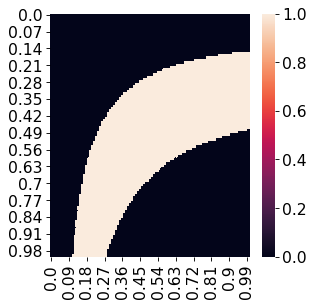

In [94]:
# alpha on Y axis, beta on X
sns.heatmap(alpha_beta_bin_matrix)